In [488]:
import os

import pandas as pd
import numpy as np

from utils.plotting import plot_histogram_kde

from scipy import stats

from statsmodels.api import qqplot

import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")

In [489]:
DATA_PATH = "../data"

In [490]:
os.listdir(DATA_PATH)

datasets = {}

for car in os.listdir(DATA_PATH):
    datasets[car] = {}

    for obd_type in os.listdir(DATA_PATH + "/" + car):
        datasets[car][obd_type] = {}

        for csv_file in os.listdir(DATA_PATH + "/" + car + "/" + obd_type):
            if "debug" in csv_file:
                datasets[car][obd_type]["debug"] = pd.read_csv(DATA_PATH + "/" + car + "/" + obd_type + "/" + csv_file)
            else:
                datasets[car][obd_type]["data"] = pd.read_csv(DATA_PATH + "/" + car + "/" + obd_type + "/" + csv_file)

In [491]:
density_and_emission = {
    "Gasolina": [737, 2310],
    "Diesel": [850, 2660],
    "Etanol": [789, 1510]
}

def formula_maf_afr(
    air_fuel_ratio: list,
    mass_air_flow: list,
    fuel_type: str
):
    fuel_density = density_and_emission[fuel_type][0]
    emission_factor_CO2 = density_and_emission[fuel_type][1]
    co2_emissions = []

    for afr, maf in zip(air_fuel_ratio, mass_air_flow):
        if fuel_type == "Gasolina":
            afr = 14.7
        elif fuel_type == "Etanol":
            afr = 9.1

        if maf is not None:
            fuel_volume = maf / (afr * fuel_density)
            co2_emission = fuel_volume * emission_factor_CO2 # g/s
            co2_emissions.append(round(co2_emission, 3))  # Evitar precisão exagerada
        else:
            co2_emissions.append(0)

    final = round(sum(co2_emissions), 2)

    return final, co2_emissions

def estimate_maf(rpm, temp, pressure, cc):
    """Estima o fluxo de massa de ar (MAF)"""
    VE = 0.8 # Eficiência volumétrica ajustada
    R = 8.3146 # Constante dos gases ideais
    M_air = 28.87 # Massa molar do ar seco em g/mol

    # Ajuste de unidades
    temp = temp + 273.15 # °C para Kelvin

    # Cálculo do MAF (mg/s)
    # pressure em KPa
    # cc em litros
    maf = (pressure * cc * M_air * VE * rpm) / (R * temp * 120)

    return maf  # mg/s para g/s

def compute_emissions_maf_afr(
    air_fuel_ratio: list,
    mass_air_flow: list,
    fuel_type: str,
    rpm: list,
    intake_air_temperature: list,
    intake_manifold_absolut_pressure: list,
    engine: float
):
    result = {}
    estimated_maf = []
    emissions_final = 0
    emissions_list = []

    # Cálculo direto de emissão, se possível
    emissions_final, emissions_list = formula_maf_afr(air_fuel_ratio, mass_air_flow, fuel_type)
    if emissions_final != 0:
        result["emission"] = emissions_final
        result["emission_list"] = emissions_list
        return result

    # Loop para calcular as emissões para cada instante
    for i in range(len(intake_air_temperature)):
        if any(v is None or v == 0 for v in [rpm[i], intake_air_temperature[i], intake_manifold_absolut_pressure[i]]):
            estimated_maf.append(0)
            continue

        # Cálculo do MAF estimado
        maf = estimate_maf(rpm[i], intake_air_temperature[i], intake_manifold_absolut_pressure[i], engine)
        estimated_maf.append(maf)

    emissions_final, emissions_list = formula_maf_afr(air_fuel_ratio, estimated_maf, fuel_type)

    result["emission"] = emissions_final
    result["emission_list"] = emissions_list

    return result

# Data Analysis

## Polo Prata

### OBD A

In [492]:
polo_prata_a = datasets["polo_prata"]["A"]["debug"]

polo_prata_a.head(10)

,Timestamp,CommandSent,Response,Interval,CommandsCount,ResponsesCount,Failed
0,1739464440307,speed,0.0,513,1,1,0
1,1739464440839,rpm,981.0,131,2,2,0
2,1739464440972,engine_load,16.0,90,3,3,0
3,1739464441063,engine_oil_temperature,NO DATA\r>,149,4,4,1
4,1739464441213,coolant_temp,83.0,150,5,5,1
5,1739464441363,mass_air_flow,NO DATA\r>,148,6,6,2
6,1739464441511,throttle_position,17.0,149,7,7,2
7,1739464441660,voltage_control_module,13.33,94,8,8,2
8,1739464441755,fuel_level,47.84,149,9,9,2
9,1739464441904,fuel_pressure,NO DATA\r>,147,10,10,3


In [493]:
polo_prata_a["Interval"].median()

np.float64(149.0)

In [494]:
polo_prata_a.groupby("CommandSent")["Interval"].median()

CommandSent
absolute_barometric_pressure        149.0
absolute_load_value                 150.0
absolute_throttle_pos_B             150.0
accelerator_pedal_pos_D             150.0
accelerator_pedal_pos_E             149.0
air_fuel_ratio                      149.0
catalyst_temp_bank1_sensor1         149.0
coolant_temp                        149.0
distance_traveled_with_MIL_on       149.0
engine_fuel_rate                    149.0
engine_load                         148.0
engine_oil_temperature              149.0
ethanol_percentage                  150.0
fuel_level                          149.0
fuel_pressure                       149.0
fuel_rail_gauge_pressure            149.0
fuel_rail_pressure                  149.0
intake_air_temperature              150.0
intake_manifold_absolut_pressure    150.0
mass_air_flow                       149.0
relative_throttle_pos               149.0
rpm                                 149.0
runtime_since_engine_start          149.0
speed                 

In [495]:
compute_emissions_maf_afr(
    air_fuel_ratio=polo_prata_a[
        (polo_prata_a["CommandSent"] == "air_fuel_ratio") &
        ~(polo_prata_a["Response"].str.contains("NO DATA\r>"))
    ]["Response"].values.astype(float),
    mass_air_flow=polo_prata_a[
        (polo_prata_a["CommandSent"] == "mass_air_flow") &
        ~(polo_prata_a["Response"].str.contains("NO DATA\r>"))
    ]["Response"].values.astype(float),
    fuel_type="Gasolina",
    rpm=polo_prata_a[
        (polo_prata_a["CommandSent"] == "rpm") &
        ~(polo_prata_a["Response"].str.contains("NO DATA\r>"))
    ]["Response"].values.astype(float),
    intake_air_temperature=polo_prata_a[
        (polo_prata_a["CommandSent"] == "intake_air_temperature") &
        ~(polo_prata_a["Response"].str.contains("NO DATA\r>"))
    ]["Response"].values.astype(float),
    intake_manifold_absolut_pressure=polo_prata_a[
        (polo_prata_a["CommandSent"] == "intake_manifold_absolut_pressure") &
        ~(polo_prata_a["Response"].str.contains("NO DATA\r>"))
    ]["Response"].values.astype(float),
    engine=1.0
)["emission"]

np.float64(287.08)

### OBD B

In [496]:
polo_prata_b = datasets["polo_prata"]["B"]["debug"]

polo_prata_b.head(10)

,Timestamp,CommandSent,Response,Interval,CommandsCount,ResponsesCount,Failed
0,1739460036051,speed,0.0,257,1,1,0
1,1739460036051,speed,0.0,278,1,2,0
2,1739460036330,rpm,979.0,111,2,4,0
3,1739460036330,rpm,980.0,157,2,5,0
4,1739460036488,engine_load,15.0,133,3,7,0
5,1739460036488,engine_load,15.0,179,3,8,0
6,1739460036668,engine_oil_temperature,NO DATA,136,4,10,1
7,1739460036805,coolant_temp,NO DATA,137,5,12,2
8,1739460036943,mass_air_flow,NO DATA,129,6,14,3
9,1739460037074,throttle_position,16.0,180,7,16,3


In [497]:
polo_prata_b["Interval"].median()

np.float64(178.0)

In [498]:
polo_prata_b.groupby("CommandSent")["Interval"].median()

CommandSent
absolute_barometric_pressure        178.0
absolute_load_value                 181.0
absolute_throttle_pos_B             179.0
accelerator_pedal_pos_D             180.0
accelerator_pedal_pos_E             181.0
air_fuel_ratio                      182.0
catalyst_temp_bank1_sensor1         178.0
coolant_temp                        181.0
distance_traveled_with_MIL_on       179.0
engine_fuel_rate                    132.0
engine_load                         178.0
engine_oil_temperature              132.0
ethanol_percentage                  177.0
fuel_level                          179.0
fuel_pressure                       133.0
fuel_rail_gauge_pressure            181.0
fuel_rail_pressure                  135.0
intake_air_temperature              178.0
intake_manifold_absolut_pressure    178.0
mass_air_flow                       135.0
relative_throttle_pos               178.0
rpm                                 176.0
runtime_since_engine_start          178.0
speed                 

In [499]:
compute_emissions_maf_afr(
    air_fuel_ratio=polo_prata_b[
        (polo_prata_b["CommandSent"] == "air_fuel_ratio") &
        ~(polo_prata_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    mass_air_flow=polo_prata_b[
        (polo_prata_b["CommandSent"] == "mass_air_flow") &
        ~(polo_prata_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    fuel_type="Gasolina",
    rpm=polo_prata_b[
        (polo_prata_b["CommandSent"] == "rpm") &
        ~(polo_prata_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    intake_air_temperature=polo_prata_b[
        (polo_prata_b["CommandSent"] == "intake_air_temperature") &
        ~(polo_prata_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    intake_manifold_absolut_pressure=polo_prata_b[
        (polo_prata_b["CommandSent"] == "intake_manifold_absolut_pressure") &
        ~(polo_prata_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    engine=1.0
)["emission"]

np.float64(217.16)

### Plotting

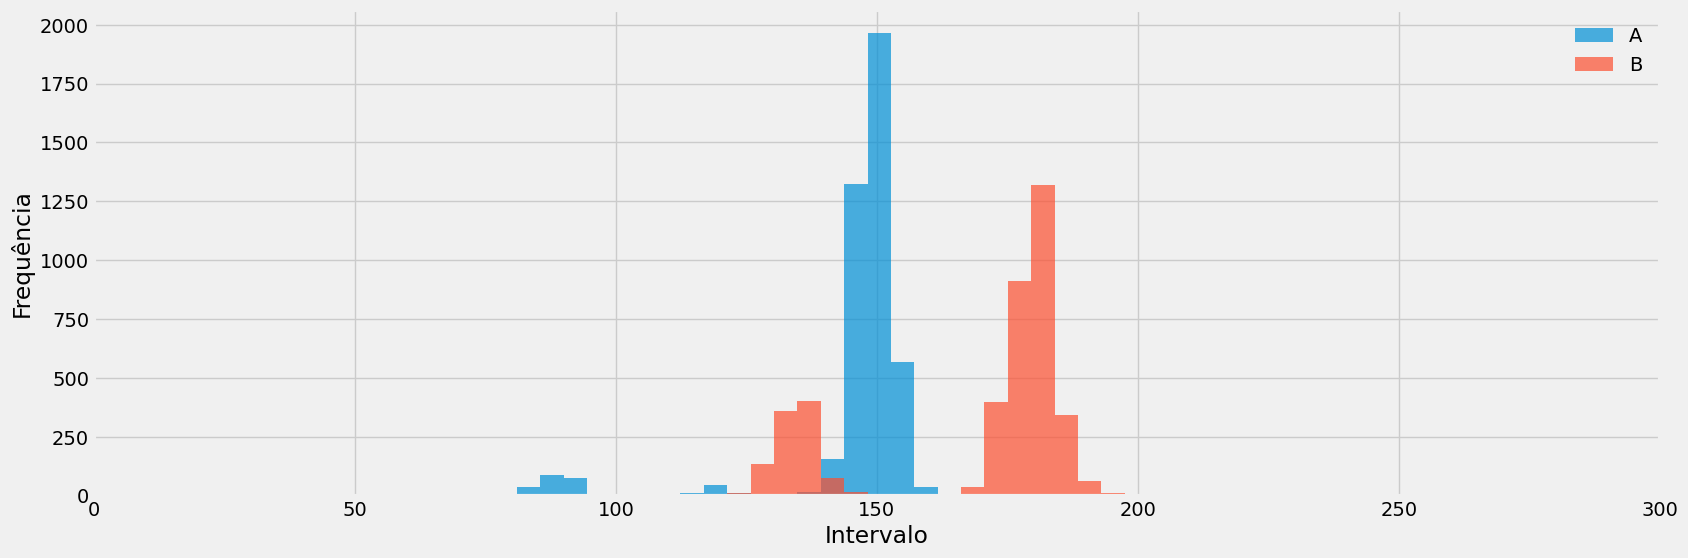

In [500]:
min_value = min(polo_prata_a["Interval"].min(), polo_prata_b["Interval"].min())
max_value = max(polo_prata_a["Interval"].max(), polo_prata_b["Interval"].max())

num_bins = 100
bins = np.linspace(min_value, max_value, num_bins + 1)

plt.figure(figsize=(18, 6))

plt.hist(polo_prata_a["Interval"], bins=bins, alpha=0.7, label="A")
plt.hist(polo_prata_b["Interval"], bins=bins, alpha=0.7, label="B")

plt.xlabel("Intervalo")
plt.ylabel("Frequência")

plt.xlim(0, 300)

plt.legend(loc="upper right", frameon=False)

plt.show()

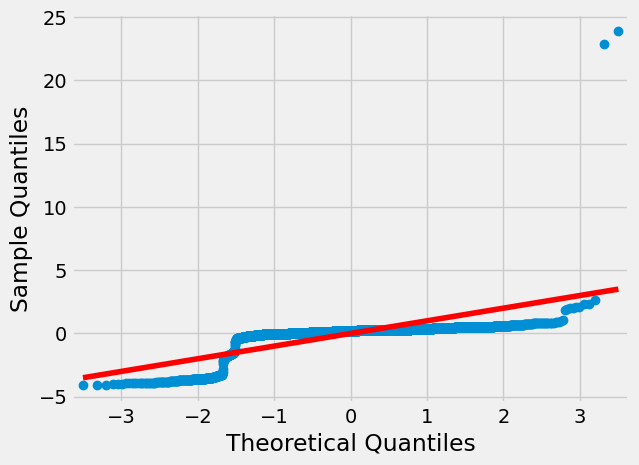

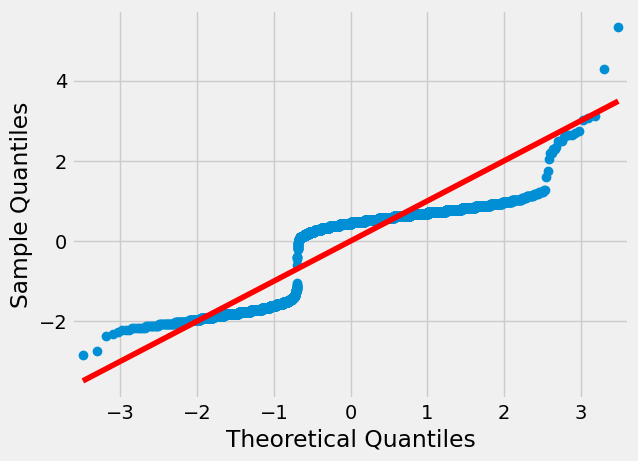

In [501]:
qqplot(polo_prata_a["Interval"].values, line="s", fit=True)
qqplot(polo_prata_b["Interval"].values, line="s", fit=True)

plt.show()

In [502]:
stats.skew(polo_prata_a["Interval"].values)

np.float64(3.61124416769398)

In [503]:
stats.skew(polo_prata_b["Interval"].values)

np.float64(-0.9430849085164158)

In [504]:
stats.kurtosis(polo_prata_a["Interval"].values)

np.float64(142.78207900164034)

In [505]:
stats.kurtosis(polo_prata_b["Interval"].values)

np.float64(-0.19250972312097714)

In [506]:
stats.kstest(polo_prata_a["Interval"].values, "norm", args=(polo_prata_a["Interval"].mean(), polo_prata_a["Interval"].std()))

KstestResult(statistic=np.float64(0.3439720995467117), pvalue=np.float64(0.0), statistic_location=np.int64(145), statistic_sign=np.int8(-1))

In [507]:
stats.kstest(polo_prata_b["Interval"].values, "norm", args=(polo_prata_b["Interval"].mean(), polo_prata_b["Interval"].std()))

KstestResult(statistic=np.float64(0.2991763115398028), pvalue=np.float64(0.0), statistic_location=np.int64(174), statistic_sign=np.int8(-1))

In [508]:
stat, p = stats.mannwhitneyu(
    polo_prata_a["Interval"].values,
    polo_prata_b["Interval"].values,
    alternative='two-sided'
)

stat, p

(np.float64(4090026.5), np.float64(0.0))

## Polo Branco

### OBD A

In [509]:
polo_branco_a = datasets["polo_branco"]["A"]["debug"]

polo_branco_a.head(10)

,Timestamp,CommandSent,Response,Interval,CommandsCount,ResponsesCount,Failed
0,1739984710529,speed,0.0,272,1,1,0
1,1739984710819,rpm,980.0,137,2,2,0
2,1739984710956,engine_load,16.0,145,3,3,0
3,1739984711101,engine_oil_temperature,NO DATA\r>,154,4,4,1
4,1739984711255,coolant_temp,87.0,150,5,5,1
5,1739984711405,mass_air_flow,NO DATA\r>,148,6,6,2
6,1739984711553,throttle_position,16.0,147,7,7,2
7,1739984711700,voltage_control_module,13.52,151,8,8,2
8,1739984711851,fuel_level,67.84,148,9,9,2
9,1739984711999,fuel_pressure,NO DATA\r>,156,10,10,3


In [510]:
polo_branco_a["Interval"].median()

np.float64(149.0)

In [511]:
polo_branco_a.groupby("CommandSent")["Interval"].median()

CommandSent
absolute_barometric_pressure        149.0
absolute_load_value                 147.0
absolute_throttle_pos_B             148.0
accelerator_pedal_pos_D             149.0
accelerator_pedal_pos_E             149.0
air_fuel_ratio                      149.0
catalyst_temp_bank1_sensor1         149.0
coolant_temp                        148.0
distance_traveled_with_MIL_on       149.0
engine_fuel_rate                    147.0
engine_load                         149.0
engine_oil_temperature              147.0
ethanol_percentage                  149.0
fuel_level                          148.5
fuel_pressure                       149.5
fuel_rail_gauge_pressure            149.0
fuel_rail_pressure                  148.5
intake_air_temperature              149.0
intake_manifold_absolut_pressure    149.5
mass_air_flow                       150.0
relative_throttle_pos               149.0
rpm                                 149.0
runtime_since_engine_start          149.0
speed                 

In [512]:
compute_emissions_maf_afr(
    air_fuel_ratio=polo_branco_a[
        (polo_branco_a["CommandSent"] == "air_fuel_ratio") &
        ~(polo_branco_a["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    mass_air_flow=polo_branco_a[
        (polo_branco_a["CommandSent"] == "mass_air_flow") &
        ~(polo_branco_a["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    fuel_type="Gasolina",
    rpm=polo_branco_a[
        (polo_branco_a["CommandSent"] == "rpm") &
        ~(polo_branco_a["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    intake_air_temperature=polo_branco_a[
        (polo_branco_a["CommandSent"] == "intake_air_temperature") &
        ~(polo_branco_a["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    intake_manifold_absolut_pressure=polo_branco_a[
        (polo_branco_a["CommandSent"] == "intake_manifold_absolut_pressure") &
        ~(polo_branco_a["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    engine=1.0
)["emission"]

np.float64(283.53)

### OBD B

In [513]:
polo_branco_b = datasets["polo_branco"]["B"]["debug"]

polo_branco_b.head(10)

,Timestamp,CommandSent,Response,Interval,CommandsCount,ResponsesCount,Failed
0,1739985360356,speed,0.0,237,1,1,0
1,1739985360356,speed,0.0,244,1,2,0
2,1739985360600,rpm,980.0,171,2,4,0
3,1739985360600,rpm,974.0,172,2,5,0
4,1739985360772,engine_load,13.0,178,3,7,0
5,1739985360772,engine_load,13.0,179,3,8,0
6,1739985360951,engine_oil_temperature,NO DATA,134,4,10,1
7,1739985361086,coolant_temp,87.0,180,5,12,1
8,1739985361086,coolant_temp,87.0,181,5,13,1
9,1739985361269,mass_air_flow,NO DATA,125,6,15,2


In [514]:
polo_branco_b["Interval"].median()

np.float64(179.0)

In [515]:
polo_branco_b.groupby("CommandSent")["Interval"].median()

CommandSent
absolute_barometric_pressure        178.0
absolute_load_value                 180.0
absolute_throttle_pos_B             178.0
accelerator_pedal_pos_D             180.0
accelerator_pedal_pos_E             178.0
air_fuel_ratio                      180.0
catalyst_temp_bank1_sensor1         178.0
coolant_temp                        180.0
distance_traveled_with_MIL_on       178.0
engine_fuel_rate                    133.0
engine_load                         179.0
engine_oil_temperature              131.0
ethanol_percentage                  179.0
fuel_level                          177.0
fuel_pressure                       134.0
fuel_rail_gauge_pressure            180.0
fuel_rail_pressure                  133.0
intake_air_temperature              179.0
intake_manifold_absolut_pressure    179.0
mass_air_flow                       135.0
relative_throttle_pos               179.0
rpm                                 179.0
runtime_since_engine_start          178.0
speed                 

In [516]:
compute_emissions_maf_afr(
    air_fuel_ratio=polo_branco_b[
        (polo_branco_b["CommandSent"] == "air_fuel_ratio") &
        ~(polo_branco_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    mass_air_flow=polo_branco_b[
        (polo_branco_b["CommandSent"] == "mass_air_flow") &
        ~(polo_branco_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    fuel_type="Gasolina",
    rpm=polo_branco_b[
        (polo_branco_b["CommandSent"] == "rpm") &
        ~(polo_branco_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    intake_air_temperature=polo_branco_b[
        (polo_branco_b["CommandSent"] == "intake_air_temperature") &
        ~(polo_branco_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    intake_manifold_absolut_pressure=polo_branco_b[
        (polo_branco_b["CommandSent"] == "intake_manifold_absolut_pressure") &
        ~(polo_branco_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    engine=1.0
)["emission"]

np.float64(211.63)

### Plotting

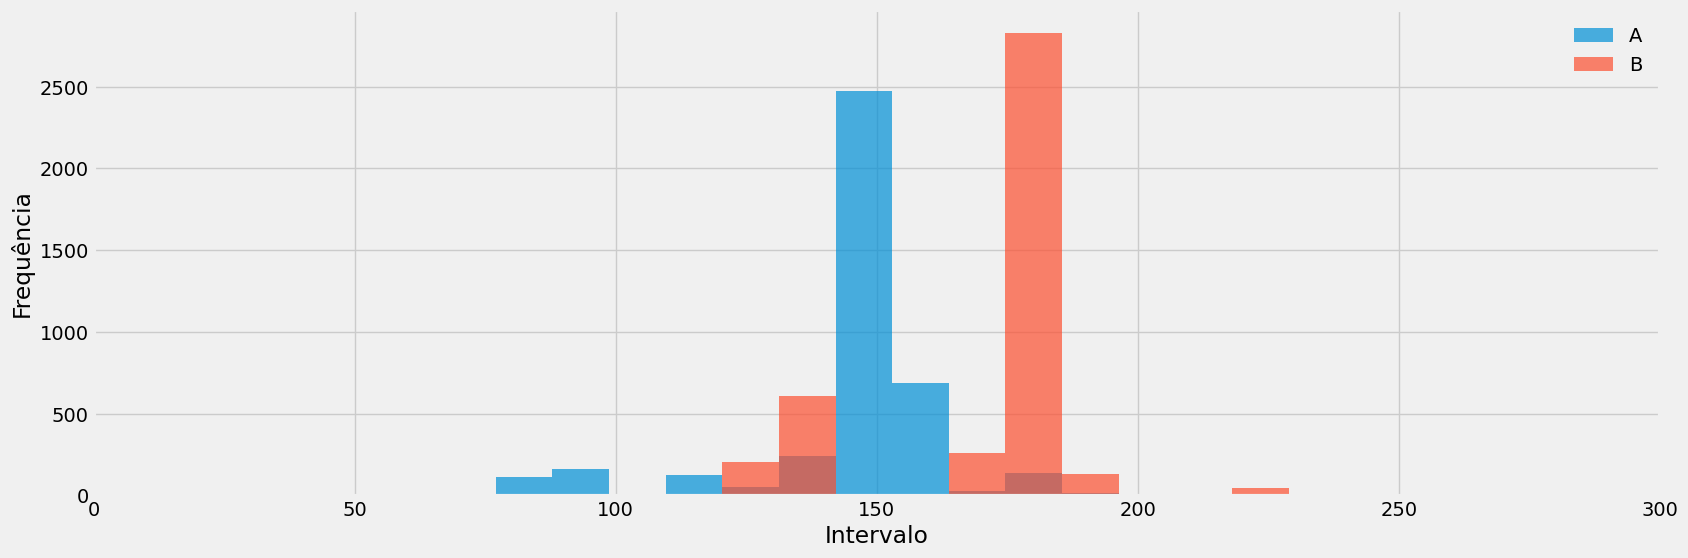

In [517]:
min_value = min(polo_branco_a["Interval"].min(), polo_branco_b["Interval"].min())
max_value = max(polo_branco_a["Interval"].max(), polo_branco_b["Interval"].max())

num_bins = 100
bins = np.linspace(min_value, max_value, num_bins + 1)

plt.figure(figsize=(18, 6))

plt.hist(polo_branco_a["Interval"], bins=bins, alpha=0.7, label="A")
plt.hist(polo_branco_b["Interval"], bins=bins, alpha=0.7, label="B")

plt.xlabel("Intervalo")
plt.ylabel("Frequência")

plt.xlim(0, 300)

plt.legend(loc="upper right", frameon=False)

plt.show()

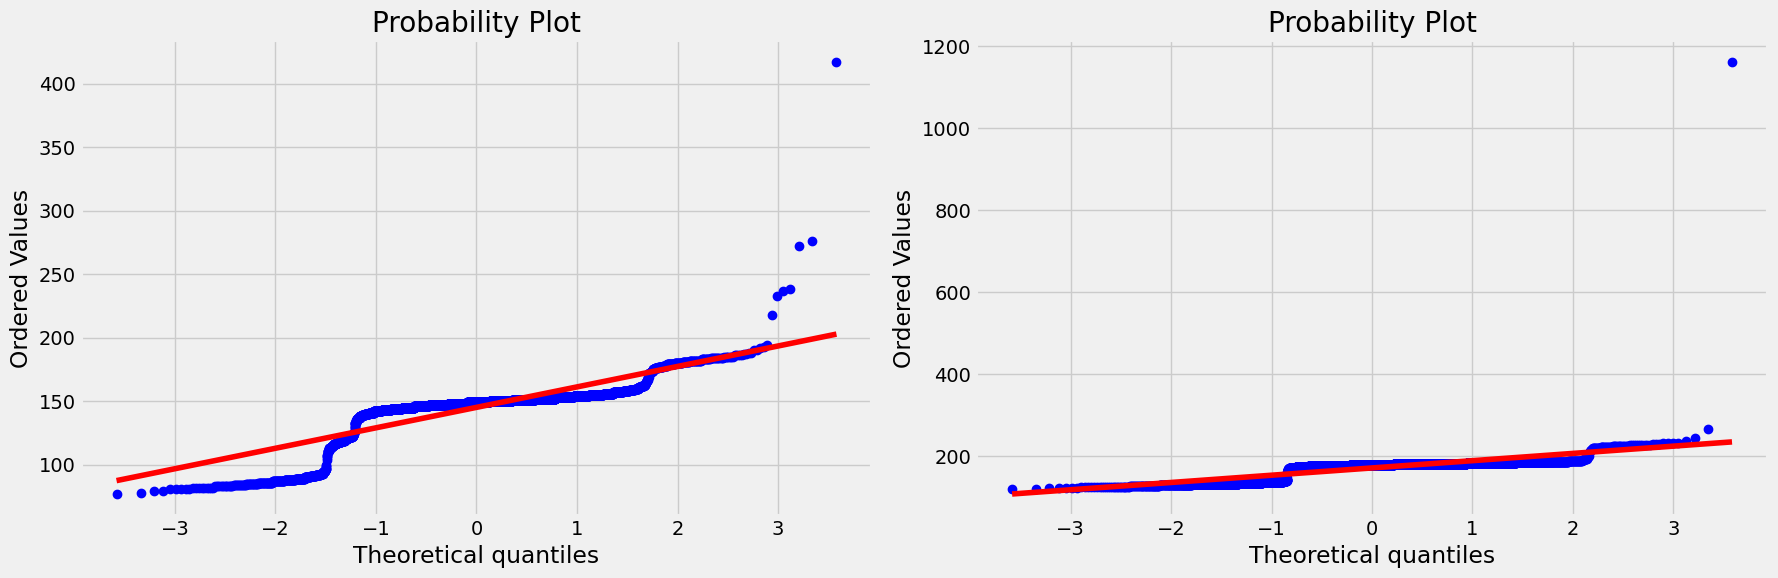

In [518]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

stats.probplot(polo_branco_a["Interval"].values, dist="norm", plot=ax[0])

stats.probplot(polo_branco_b["Interval"].values, dist="norm", plot=ax[1])

plt.tight_layout()
plt.show()

In [519]:
stats.skew(polo_branco_a["Interval"].values)

np.float64(-0.6762826073492635)

In [520]:
stats.skew(polo_branco_b["Interval"].values)

np.float64(14.404357556249932)

In [521]:
stats.kurtosis(polo_branco_a["Interval"].values)

np.float64(14.225016780569263)

In [522]:
stats.kurtosis(polo_branco_b["Interval"].values)

np.float64(585.2665025810905)

In [523]:
stats.kstest(polo_branco_a["Interval"].values, "norm", args=(polo_branco_a["Interval"].mean(), polo_branco_a["Interval"].std()))

KstestResult(statistic=np.float64(0.28244186009567174), pvalue=np.float64(2.5618177597438973e-286), statistic_location=np.int64(143), statistic_sign=np.int8(-1))

In [524]:
stats.kstest(polo_branco_b["Interval"].values, "norm", args=(polo_branco_b["Interval"].mean(), polo_branco_b["Interval"].std()))

KstestResult(statistic=np.float64(0.30481394098968895), pvalue=np.float64(0.0), statistic_location=np.int64(174), statistic_sign=np.int8(-1))

In [525]:
stat, p = stats.mannwhitneyu(
    polo_branco_a["Interval"].values,
    polo_branco_b["Interval"].values,
    alternative='two-sided'
)

stat, p

(np.float64(3234063.5), np.float64(0.0))

## Fit

### OBD A

In [526]:
fit_a = datasets["fit"]["A"]["debug"]

fit_a.head(10)

,Timestamp,CommandSent,Response,Interval,CommandsCount,ResponsesCount,Failed
0,1739465416416,speed,0.0,456,1,1,0
1,1739465416892,rpm,713.0,131,2,2,0
2,1739465417024,engine_load,22.0,148,3,3,0
3,1739465417173,engine_oil_temperature,NO DATA\r>,146,4,4,1
4,1739465417319,coolant_temp,86.0,153,5,5,1
5,1739465417472,mass_air_flow,1.68,147,6,6,1
6,1739465417620,throttle_position,15.0,149,7,7,1
7,1739465417769,voltage_control_module,14.13,153,8,8,1
8,1739465417922,fuel_level,65.49,147,9,9,1
9,1739465418069,fuel_pressure,NO DATA\r>,152,10,10,2


In [527]:
fit_a["Interval"].median()

np.float64(149.0)

In [528]:
fit_a.groupby("CommandSent")["Interval"].median()

CommandSent
absolute_barometric_pressure        150.0
absolute_load_value                 148.0
absolute_throttle_pos_B             150.0
accelerator_pedal_pos_D             150.0
accelerator_pedal_pos_E             150.0
air_fuel_ratio                      150.0
catalyst_temp_bank1_sensor1         150.0
coolant_temp                        149.0
distance_traveled_with_MIL_on       150.0
engine_fuel_rate                    148.0
engine_load                         149.0
engine_oil_temperature              148.0
ethanol_percentage                  148.0
fuel_level                          149.0
fuel_pressure                       149.0
fuel_rail_gauge_pressure            150.0
fuel_rail_pressure                  148.0
intake_air_temperature              150.0
intake_manifold_absolut_pressure    150.0
mass_air_flow                       150.0
relative_throttle_pos               148.0
rpm                                 148.0
runtime_since_engine_start          149.0
speed                 

In [529]:
compute_emissions_maf_afr(
    air_fuel_ratio=fit_a[
        (fit_a["CommandSent"] == "air_fuel_ratio") &
        ~(fit_a["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    mass_air_flow=fit_a[
        (fit_a["CommandSent"] == "mass_air_flow") &
        ~(fit_a["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    fuel_type="Gasolina",
    rpm=fit_a[
        (fit_a["CommandSent"] == "rpm") &
        ~(fit_a["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    intake_air_temperature=fit_a[
        (fit_a["CommandSent"] == "intake_air_temperature") &
        ~(fit_a["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    intake_manifold_absolut_pressure=fit_a[
        (fit_a["CommandSent"] == "intake_manifold_absolut_pressure") &
        ~(fit_a["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    engine=1.6
)["emission"]

np.float64(223.0)

### OBD B

In [530]:
fit_b = datasets["fit"]["B"]["debug"]

fit_b.head(10)

,Timestamp,CommandSent,Response,Interval,CommandsCount,ResponsesCount,Failed
0,1739466128746,speed,0.0,159,1,1,0
1,1739466128948,rpm,743.0,135,2,3,0
2,1739466129133,engine_load,19.0,133,3,5,0
3,1739466129308,engine_oil_temperature,NO DATA,136,4,7,1
4,1739466129445,coolant_temp,90.0,135,5,9,1
5,1739466129623,mass_air_flow,1.59,135,6,11,1
6,1739466129803,throttle_position,14.0,137,7,13,1
7,1739466129983,voltage_control_module,14.1,136,8,15,1
8,1739466130165,fuel_level,65.1,134,9,17,1
9,1739466130344,fuel_pressure,NO DATA,139,10,19,2


In [531]:
fit_b["Interval"].median()

np.float64(136.0)

In [532]:
fit_b.groupby("CommandSent")["Interval"].median()

CommandSent
absolute_barometric_pressure        136.0
absolute_load_value                 135.0
absolute_throttle_pos_B             137.0
accelerator_pedal_pos_D             136.0
accelerator_pedal_pos_E             136.0
air_fuel_ratio                      136.0
catalyst_temp_bank1_sensor1         136.0
coolant_temp                        134.5
distance_traveled_with_MIL_on       136.0
engine_fuel_rate                    136.0
engine_load                         135.0
engine_oil_temperature              136.0
ethanol_percentage                  136.0
fuel_level                          136.0
fuel_pressure                       136.0
fuel_rail_gauge_pressure            135.0
fuel_rail_pressure                  133.5
intake_air_temperature              136.0
intake_manifold_absolut_pressure    135.0
mass_air_flow                       136.0
relative_throttle_pos               136.0
rpm                                 136.0
runtime_since_engine_start          136.0
speed                 

In [533]:
compute_emissions_maf_afr(
    air_fuel_ratio=fit_b[
        (fit_b["CommandSent"] == "air_fuel_ratio") &
        ~(fit_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    mass_air_flow=fit_b[
        (fit_b["CommandSent"] == "mass_air_flow") &
        ~(fit_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    fuel_type="Gasolina",
    rpm=fit_b[
        (fit_b["CommandSent"] == "rpm") &
        ~(fit_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    intake_air_temperature=fit_b[
        (fit_b["CommandSent"] == "intake_air_temperature") &
        ~(fit_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    intake_manifold_absolut_pressure=fit_b[
        (fit_b["CommandSent"] == "intake_manifold_absolut_pressure") &
        ~(fit_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    engine=1.6
)["emission"]

np.float64(178.34)

### Plotting

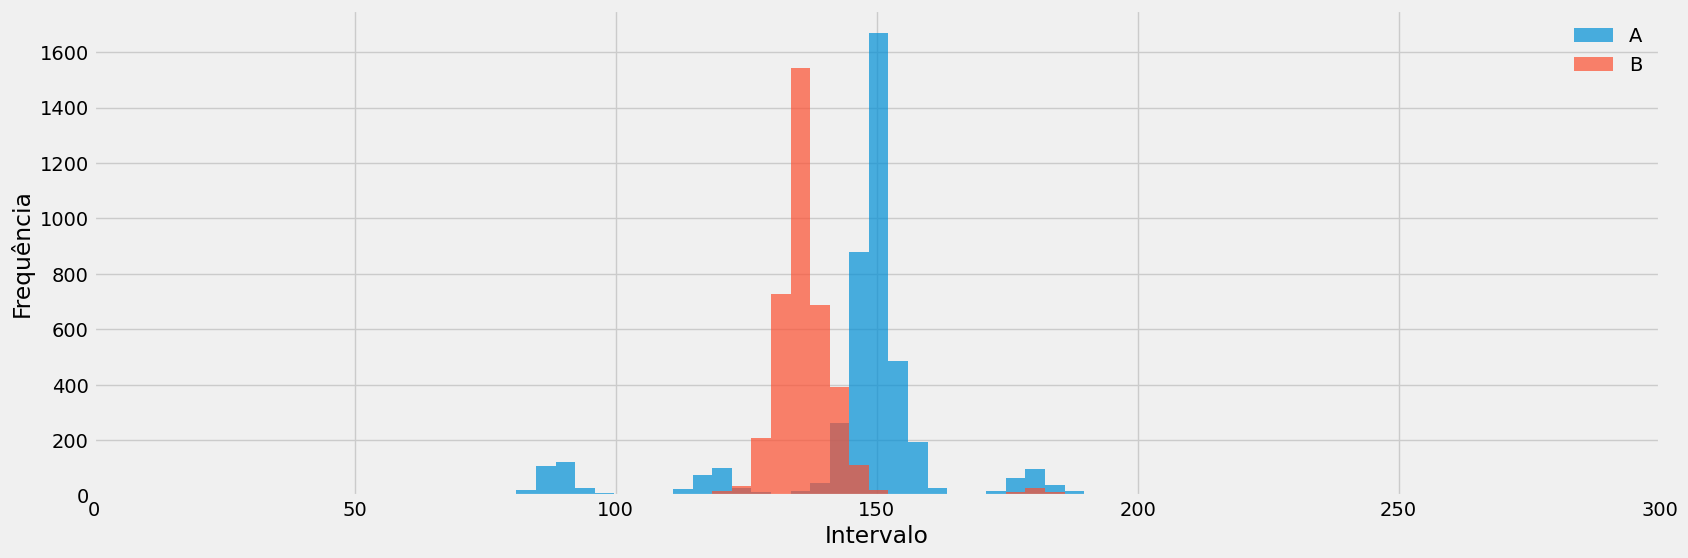

In [534]:
min_value = min(fit_a["Interval"].min(), fit_b["Interval"].min())
max_value = max(fit_a["Interval"].max(), fit_b["Interval"].max())

num_bins = 100
bins = np.linspace(min_value, max_value, num_bins + 1)

plt.figure(figsize=(18, 6))

plt.hist(fit_a["Interval"], bins=bins, alpha=0.7, label="A")
plt.hist(fit_b["Interval"], bins=bins, alpha=0.7, label="B")

plt.xlabel("Intervalo")
plt.ylabel("Frequência")

plt.xlim(0, 300)

plt.legend(loc="upper right", frameon=False)

plt.show()

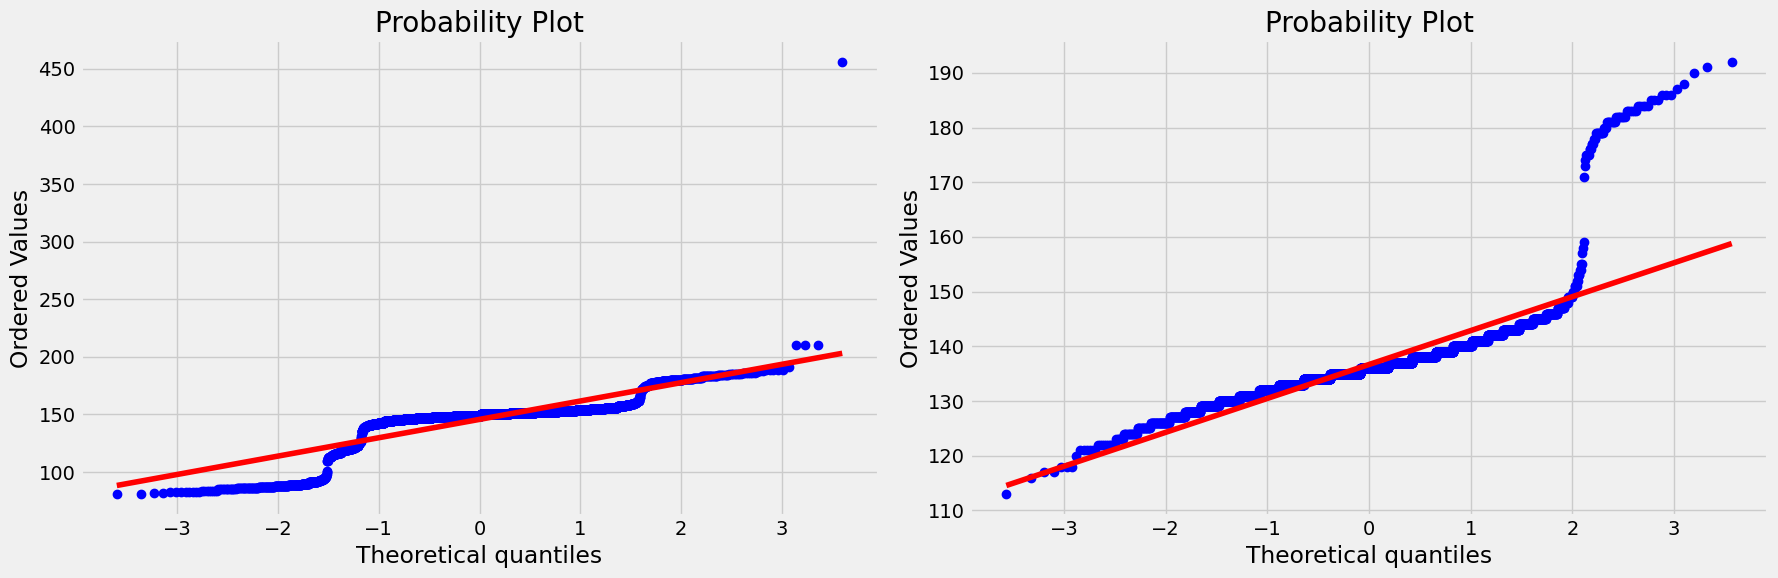

In [535]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

stats.probplot(fit_a["Interval"].values, dist="norm", plot=ax[0])

stats.probplot(fit_b["Interval"].values, dist="norm", plot=ax[1])

plt.tight_layout()
plt.show()

In [536]:
stats.skew(fit_a["Interval"].values)

np.float64(-0.5335385417028382)

In [537]:
stats.skew(fit_b["Interval"].values)

np.float64(3.5897090849144453)

In [538]:
stats.kurtosis(fit_a["Interval"].values)

np.float64(19.187941113923692)

In [539]:
stats.kurtosis(fit_b["Interval"].values)

np.float64(20.101822843562097)

In [540]:
stats.kstest(fit_a["Interval"].values, "norm", args=(fit_a["Interval"].mean(), fit_a["Interval"].std()))

KstestResult(statistic=np.float64(0.2908322033399026), pvalue=np.float64(0.0), statistic_location=np.int64(144), statistic_sign=np.int8(-1))

In [541]:
stats.kstest(fit_b["Interval"].values, "norm", args=(fit_b["Interval"].mean(), fit_b["Interval"].std()))

KstestResult(statistic=np.float64(0.1738297707635441), pvalue=np.float64(1.9311500410659068e-101), statistic_location=np.int64(139), statistic_sign=np.int8(1))

In [542]:
stat, p = stats.mannwhitneyu(
    fit_a["Interval"].values,
    fit_b["Interval"].values,
    alternative='two-sided'
)

stat, p

(np.float64(14150464.0), np.float64(0.0))

## Tcross

### OBD A

In [543]:
tcross_a = datasets["tcross"]["A"]["debug"]

tcross_a.head(10)

,Timestamp,CommandSent,Response,Interval,CommandsCount,ResponsesCount,Failed
0,1739468081274,speed,0.0,963,1,1,0
1,1739468082238,rpm,791.0,177,2,2,0
2,1739468082415,engine_load,31.0,119,3,3,0
3,1739468082535,engine_oil_temperature,NO DATA\r>,152,4,4,1
4,1739468082687,coolant_temp,87.0,148,5,5,1
5,1739468082835,mass_air_flow,2.03,150,6,6,1
6,1739468082985,throttle_position,17.0,152,7,7,1
7,1739468083137,voltage_control_module,12.68,149,8,8,1
8,1739468083286,fuel_level,51.76,150,9,9,1
9,1739468083436,fuel_pressure,NO DATA\r>,180,10,10,2


In [544]:
tcross_a["Interval"].median()

np.float64(150.0)

In [545]:
tcross_a.groupby("CommandSent")["Interval"].median()

CommandSent
absolute_barometric_pressure        150.0
absolute_load_value                 150.0
absolute_throttle_pos_B             150.0
accelerator_pedal_pos_D             150.0
accelerator_pedal_pos_E             149.5
air_fuel_ratio                      150.0
catalyst_temp_bank1_sensor1         150.0
coolant_temp                        150.0
distance_traveled_with_MIL_on       150.0
engine_fuel_rate                    149.5
engine_load                         150.0
engine_oil_temperature              149.0
ethanol_percentage                  149.5
fuel_level                          150.0
fuel_pressure                       150.0
fuel_rail_gauge_pressure            150.0
fuel_rail_pressure                  150.0
intake_air_temperature              150.0
intake_manifold_absolut_pressure    150.0
mass_air_flow                       150.0
relative_throttle_pos               150.0
rpm                                 149.0
runtime_since_engine_start          149.0
speed                 

In [546]:
compute_emissions_maf_afr(
    air_fuel_ratio=tcross_a[
        (tcross_a["CommandSent"] == "air_fuel_ratio") &
        ~(tcross_a["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    mass_air_flow=tcross_a[
        (tcross_a["CommandSent"] == "mass_air_flow") &
        ~(tcross_a["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    fuel_type="Gasolina",
    rpm=tcross_a[
        (tcross_a["CommandSent"] == "rpm") &
        ~(tcross_a["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    intake_air_temperature=tcross_a[
        (tcross_a["CommandSent"] == "intake_air_temperature") &
        ~(tcross_a["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    intake_manifold_absolut_pressure=tcross_a[
        (tcross_a["CommandSent"] == "intake_manifold_absolut_pressure") &
        ~(tcross_a["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    engine=1.0
)["emission"]

np.float64(207.59)

### OBD B

In [547]:
tcross_b = datasets["tcross"]["B"]["debug"]

tcross_b.head(10)

,Timestamp,CommandSent,Response,Interval,CommandsCount,ResponsesCount,Failed
0,1739468741420,speed,0.0,201,1,1,0
1,1739468741622,rpm,750.0,224,2,3,0
2,1739468741847,engine_load,33.0,271,3,5,0
3,1739468742119,engine_oil_temperature,NO DATA,222,4,7,1
4,1739468742343,coolant_temp,87.0,132,5,9,1
5,1739468742520,mass_air_flow,2.2,136,6,11,1
6,1739468742701,throttle_position,17.0,225,7,13,1
7,1739468743027,voltage_control_module,13.11,218,8,15,1
8,1739468743245,fuel_level,48.63,196,9,17,1
9,1739468743476,fuel_pressure,NO DATA,486,10,19,2


In [548]:
tcross_b["Interval"].median()

np.float64(169.0)

In [549]:
tcross_b.groupby("CommandSent")["Interval"].median()

CommandSent
absolute_barometric_pressure        175.5
absolute_load_value                 177.0
absolute_throttle_pos_B             178.0
accelerator_pedal_pos_D             178.0
accelerator_pedal_pos_E             177.5
air_fuel_ratio                      177.0
catalyst_temp_bank1_sensor1         177.5
coolant_temp                        177.0
distance_traveled_with_MIL_on       178.0
engine_fuel_rate                    135.0
engine_load                         177.0
engine_oil_temperature              134.0
ethanol_percentage                  177.0
fuel_level                          177.0
fuel_pressure                       135.0
fuel_rail_gauge_pressure            135.0
fuel_rail_pressure                  135.0
intake_air_temperature              178.0
intake_manifold_absolut_pressure    135.0
mass_air_flow                       176.0
relative_throttle_pos               178.0
rpm                                 176.0
runtime_since_engine_start          177.0
speed                 

In [550]:
compute_emissions_maf_afr(
    air_fuel_ratio=tcross_b[
        (tcross_b["CommandSent"] == "air_fuel_ratio") &
        ~(tcross_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    mass_air_flow=tcross_b[
        (tcross_b["CommandSent"] == "mass_air_flow") &
        ~(tcross_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    fuel_type="Gasolina",
    rpm=tcross_b[
        (tcross_b["CommandSent"] == "rpm") &
        ~(tcross_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    intake_air_temperature=tcross_b[
        (tcross_b["CommandSent"] == "intake_air_temperature") &
        ~(tcross_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    intake_manifold_absolut_pressure=tcross_b[
        (tcross_b["CommandSent"] == "intake_manifold_absolut_pressure") &
        ~(tcross_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    engine=1.0
)["emission"]

np.float64(184.0)

### Plotting

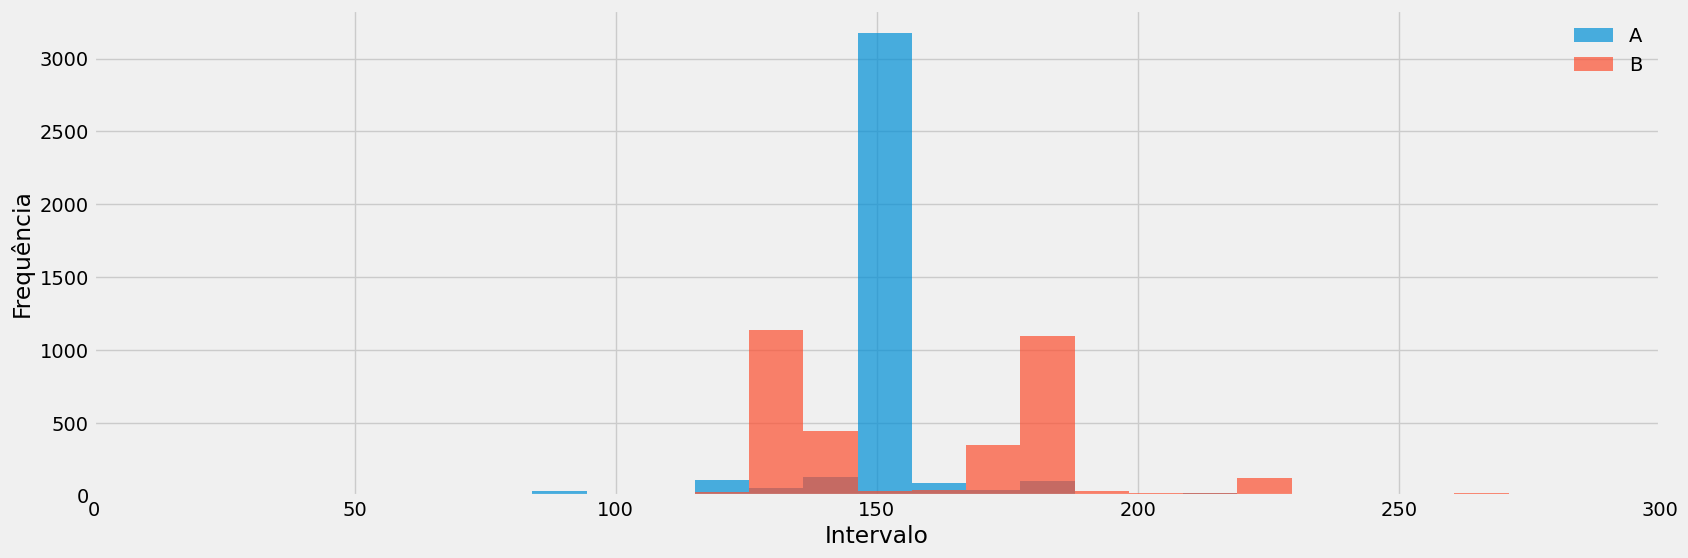

In [551]:
min_value = min(tcross_a["Interval"].min(), tcross_b["Interval"].min())
max_value = max(tcross_a["Interval"].max(), tcross_b["Interval"].max())

num_bins = 100
bins = np.linspace(min_value, max_value, num_bins + 1)

plt.figure(figsize=(18, 6))

plt.hist(tcross_a["Interval"], bins=bins, alpha=0.7, label="A")
plt.hist(tcross_b["Interval"], bins=bins, alpha=0.7, label="B")

plt.xlabel("Intervalo")
plt.ylabel("Frequência")

plt.xlim(0, 300)

plt.legend(loc="upper right", frameon=False)

plt.show()

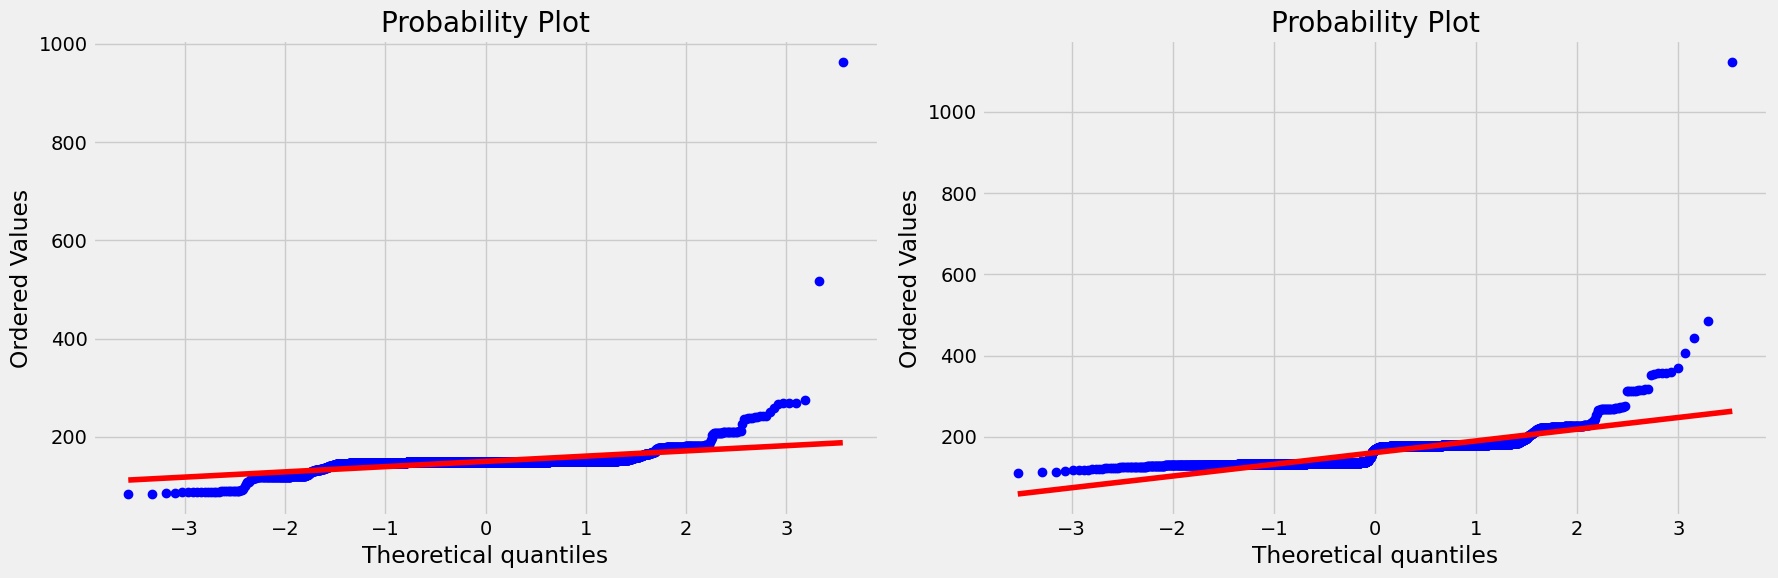

In [552]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

stats.probplot(tcross_a["Interval"].values, dist="norm", plot=ax[0])

stats.probplot(tcross_b["Interval"].values, dist="norm", plot=ax[1])

plt.tight_layout()
plt.show()

In [553]:
stats.skew(tcross_a["Interval"].values)

np.float64(21.145224615433673)

In [554]:
stats.skew(tcross_b["Interval"].values)

np.float64(7.073858182113214)

In [555]:
stats.kurtosis(tcross_a["Interval"].values)

np.float64(815.4281632457753)

In [556]:
stats.kurtosis(tcross_b["Interval"].values)

np.float64(157.97067243503287)

In [557]:
stats.kstest(tcross_a["Interval"].values, "norm", args=(tcross_a["Interval"].mean(), tcross_a["Interval"].std()))

KstestResult(statistic=np.float64(0.37232908961167643), pvalue=np.float64(0.0), statistic_location=np.int64(152), statistic_sign=np.int8(1))

In [558]:
stats.kstest(tcross_b["Interval"].values, "norm", args=(tcross_b["Interval"].mean(), tcross_b["Interval"].std()))

KstestResult(statistic=np.float64(0.2037743380240789), pvalue=np.float64(4.6219411718445424e-123), statistic_location=np.int64(138), statistic_sign=np.int8(1))

In [559]:
stat, p = stats.mannwhitneyu(
    tcross_a["Interval"].values,
    tcross_b["Interval"].values,
    alternative='two-sided'
)

stat, p

(np.float64(5985305.5), np.float64(1.8296594095925736e-05))

## HB20

### OBD A

In [560]:
hb20_a = datasets["hb20"]["A"]["debug"]

hb20_a.head(10)

,Timestamp,CommandSent,Response,Interval,CommandsCount,ResponsesCount,Failed
0,1739884777551,speed,0.0,355,1,1,0
1,1739884777907,rpm,844.0,148,2,2,0
2,1739884778055,engine_load,32.0,155,3,3,0
3,1739884778211,engine_oil_temperature,NO DATA\r>,148,4,4,1
4,1739884778359,coolant_temp,91.0,147,5,5,1
5,1739884778507,mass_air_flow,NO DATA\r>,151,6,6,2
6,1739884778658,throttle_position,13.0,147,7,7,2
7,1739884778806,voltage_control_module,14.18,151,8,8,2
8,1739884778957,fuel_level,29.02,151,9,9,2
9,1739884779109,fuel_pressure,NO DATA\r>,154,10,10,3


In [561]:
hb20_a["Interval"].median()

np.float64(137.0)

In [562]:
hb20_a.groupby("CommandSent")["Interval"].median()

CommandSent
absolute_barometric_pressure        145.5
absolute_load_value                 116.5
absolute_throttle_pos_B             120.0
accelerator_pedal_pos_D             109.0
accelerator_pedal_pos_E             143.0
air_fuel_ratio                      138.5
catalyst_temp_bank1_sensor1         143.5
coolant_temp                        144.0
distance_traveled_with_MIL_on       118.5
engine_fuel_rate                    117.0
engine_load                         118.0
engine_oil_temperature              122.0
ethanol_percentage                  117.5
fuel_level                          142.0
fuel_pressure                       116.5
fuel_rail_gauge_pressure            146.0
fuel_rail_pressure                  142.5
intake_air_temperature              109.5
intake_manifold_absolut_pressure    142.0
mass_air_flow                       123.0
relative_throttle_pos               123.5
rpm                                 100.0
runtime_since_engine_start          139.5
speed                 

In [563]:
compute_emissions_maf_afr(
    air_fuel_ratio=hb20_a[
        (hb20_a["CommandSent"] == "air_fuel_ratio") &
        ~(hb20_a["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    mass_air_flow=hb20_a[
        (hb20_a["CommandSent"] == "mass_air_flow") &
        ~(hb20_a["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    fuel_type="Gasolina",
    rpm=hb20_a[
        (hb20_a["CommandSent"] == "rpm") &
        ~(hb20_a["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    intake_air_temperature=hb20_a[
        (hb20_a["CommandSent"] == "intake_air_temperature") &
        ~(hb20_a["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    intake_manifold_absolut_pressure=hb20_a[
        (hb20_a["CommandSent"] == "intake_manifold_absolut_pressure") &
        ~(hb20_a["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    engine=1.0
)["emission"]

np.float64(296.38)

### OBD B

In [564]:
hb20_b = datasets["hb20"]["B"]["debug"]

hb20_b.head(10)

,Timestamp,CommandSent,Response,Interval,CommandsCount,ResponsesCount,Failed
0,1739885442664,speed,0.0,191,1,1,0
1,1739885442855,rpm,846.0,184,2,3,0
2,1739885443039,engine_load,26.0,177,3,5,0
3,1739885443218,engine_oil_temperature,NO DATA,136,4,7,1
4,1739885443354,coolant_temp,90.0,179,5,9,1
5,1739885443533,mass_air_flow,NO DATA,135,6,11,2
6,1739885443669,throttle_position,13.0,178,7,13,2
7,1739885443848,voltage_control_module,14.01,187,8,15,2
8,1739885444035,fuel_level,27.06,174,9,17,2
9,1739885444210,fuel_pressure,NO DATA,129,10,19,3


In [565]:
hb20_b["Interval"].median()

np.float64(179.0)

In [566]:
hb20_b.groupby("CommandSent")["Interval"].median()

CommandSent
absolute_barometric_pressure        179.0
absolute_load_value                 180.0
absolute_throttle_pos_B             179.0
accelerator_pedal_pos_D             179.0
accelerator_pedal_pos_E             179.0
air_fuel_ratio                      179.0
catalyst_temp_bank1_sensor1         179.0
coolant_temp                        180.0
distance_traveled_with_MIL_on       179.0
engine_fuel_rate                    134.0
engine_load                         179.0
engine_oil_temperature              134.0
ethanol_percentage                  179.0
fuel_level                          179.0
fuel_pressure                       134.0
fuel_rail_gauge_pressure            180.0
fuel_rail_pressure                  135.0
intake_air_temperature              179.0
intake_manifold_absolut_pressure    179.0
mass_air_flow                       134.0
relative_throttle_pos               179.0
rpm                                 179.0
runtime_since_engine_start          179.0
speed                 

In [567]:
compute_emissions_maf_afr(
    air_fuel_ratio=hb20_b[
        (hb20_b["CommandSent"] == "air_fuel_ratio") &
        ~(hb20_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    mass_air_flow=hb20_b[
        (hb20_b["CommandSent"] == "mass_air_flow") &
        ~(hb20_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    fuel_type="Gasolina",
    rpm=hb20_b[
        (hb20_b["CommandSent"] == "rpm") &
        ~(hb20_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    intake_air_temperature=hb20_b[
        (hb20_b["CommandSent"] == "intake_air_temperature") &
        ~(hb20_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    intake_manifold_absolut_pressure=hb20_b[
        (hb20_b["CommandSent"] == "intake_manifold_absolut_pressure") &
        ~(hb20_b["Response"].str.contains("NO DATA"))
    ]["Response"].values.astype(float),
    engine=1.0
)["emission"]

np.float64(217.45)

### Plotting

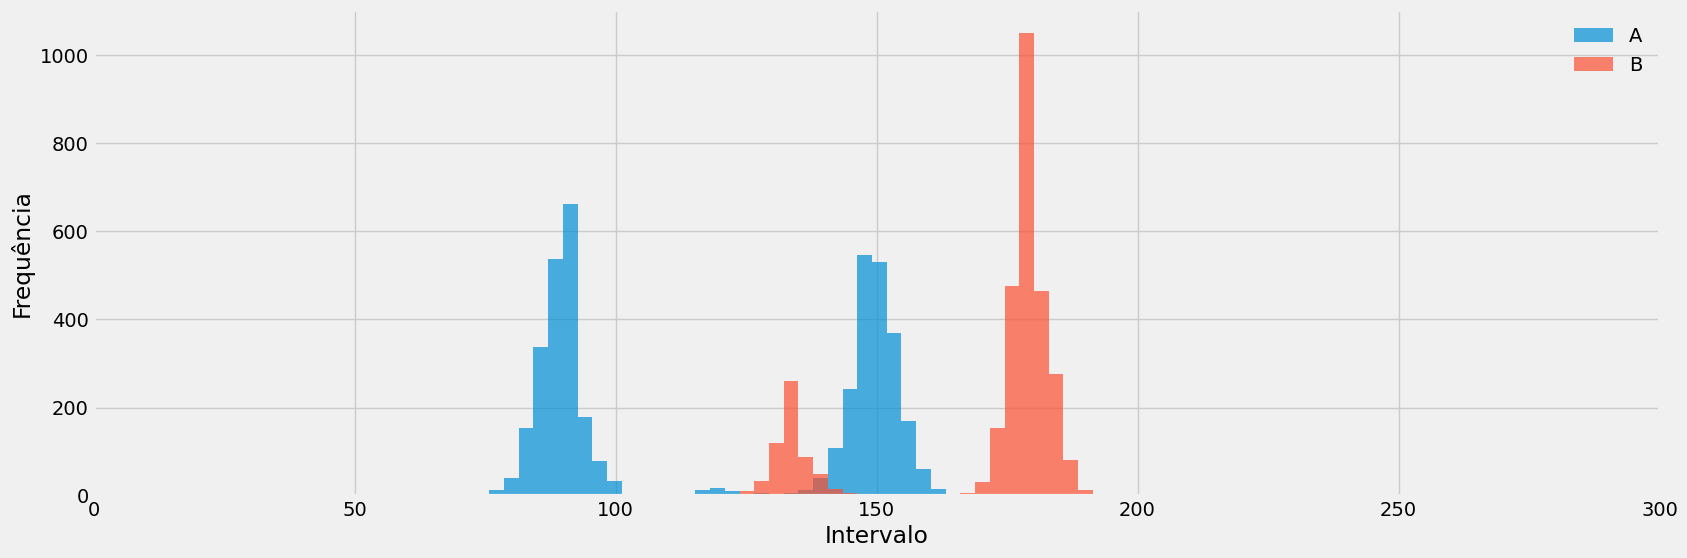

In [568]:
min_value = min(hb20_a["Interval"].min(), hb20_b["Interval"].min())
max_value = max(hb20_a["Interval"].max(), hb20_b["Interval"].max())

num_bins = 100
bins = np.linspace(min_value, max_value, num_bins + 1)

plt.figure(figsize=(18, 6))

plt.hist(hb20_a["Interval"], bins=bins, alpha=0.7, label="A")
plt.hist(hb20_b["Interval"], bins=bins, alpha=0.7, label="B")

plt.xlabel("Intervalo")
plt.ylabel("Frequência")

plt.xlim(0, 300)

plt.legend(loc="upper right", frameon=False)

plt.show()

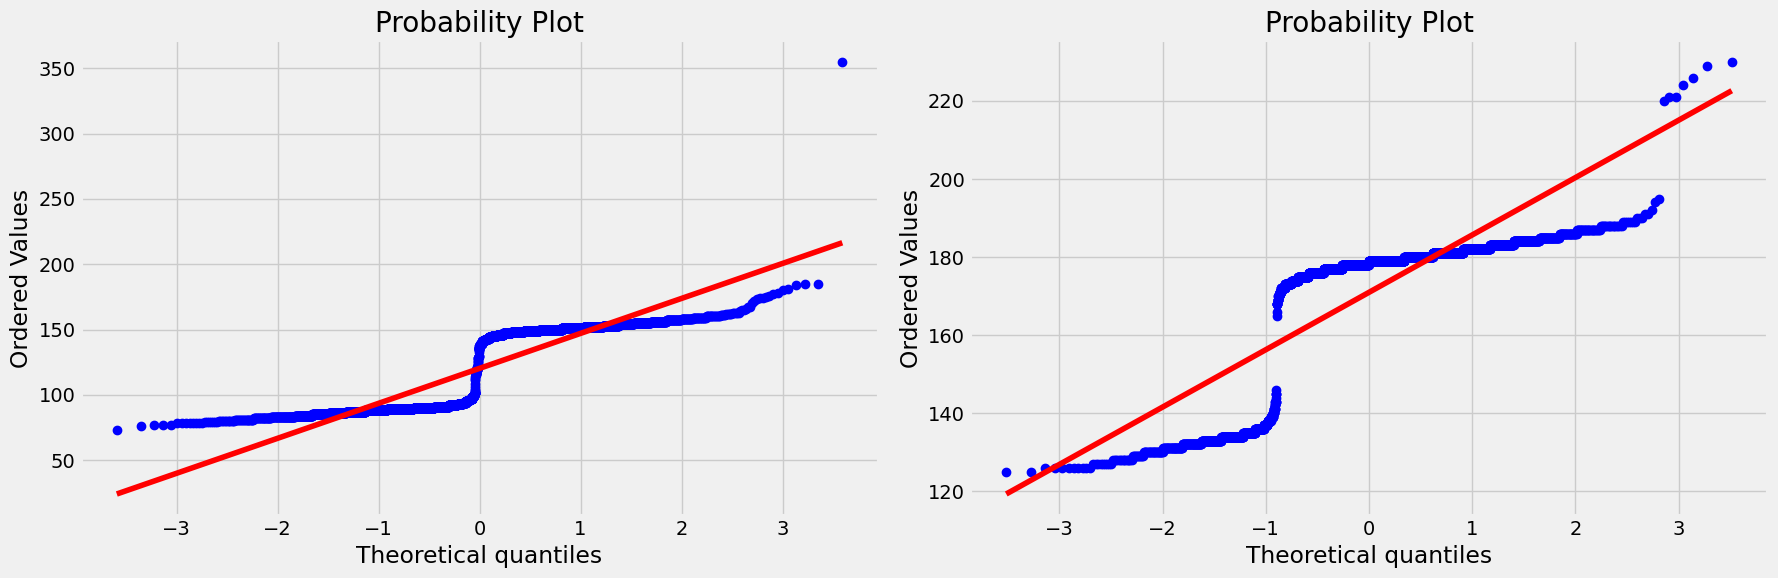

In [569]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

stats.probplot(hb20_a["Interval"].values, dist="norm", plot=ax[0])

stats.probplot(hb20_b["Interval"].values, dist="norm", plot=ax[1])

plt.tight_layout()
plt.show()

In [570]:
stats.skew(hb20_a["Interval"].values)

np.float64(0.080433921019875)

In [571]:
stats.skew(hb20_b["Interval"].values)

np.float64(-1.448791865730347)

In [572]:
stats.kurtosis(hb20_a["Interval"].values)

np.float64(-1.1040331418355043)

In [573]:
stats.kurtosis(hb20_b["Interval"].values)

np.float64(0.6525313030039275)

In [574]:
stats.kstest(hb20_a["Interval"].values, "norm", args=(hb20_a["Interval"].mean(), hb20_a["Interval"].std()))

KstestResult(statistic=np.float64(0.25077559558602747), pvalue=np.float64(5.290811323730492e-234), statistic_location=np.int64(95), statistic_sign=np.int8(1))

In [575]:
stats.kstest(hb20_b["Interval"].values, "norm", args=(hb20_b["Interval"].mean(), hb20_b["Interval"].std()))

KstestResult(statistic=np.float64(0.3420086838254249), pvalue=np.float64(0.0), statistic_location=np.int64(175), statistic_sign=np.int8(-1))

In [576]:
stat, p = stats.mannwhitneyu(
    tcross_a["Interval"].values,
    tcross_b["Interval"].values,
    alternative='two-sided'
)

stat, p

(np.float64(5985305.5), np.float64(1.8296594095925736e-05))

# General Plotting

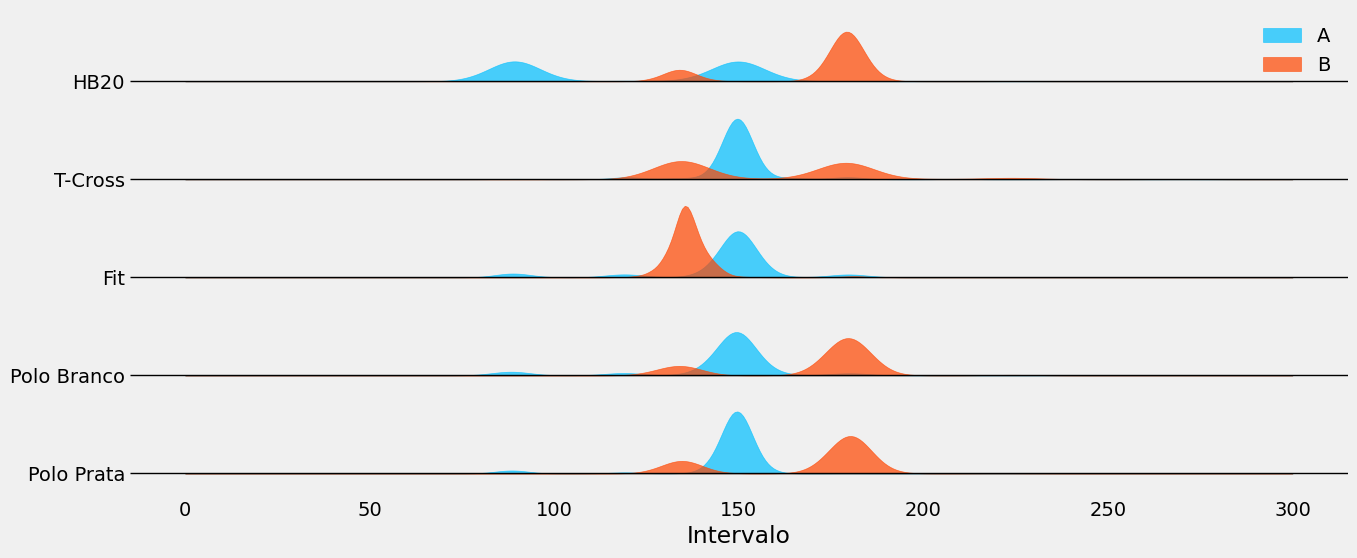

In [577]:
polo_prata_a = {"Interval": polo_prata_a["Interval"]}
polo_prata_b = {"Interval": polo_prata_b["Interval"]}
polo_branco_a = {"Interval": polo_branco_a["Interval"]}
polo_branco_b = {"Interval": polo_branco_b["Interval"]}
fit_a = {"Interval": fit_a["Interval"]}
fit_b = {"Interval": fit_b["Interval"]}
tcross_a = {"Interval": tcross_a["Interval"]}
tcross_b = {"Interval": tcross_b["Interval"]}
hb20_a = {"Interval": hb20_a["Interval"]}
hb20_b = {"Interval": hb20_b["Interval"]}
# fastback_a = {"Interval": fastback_a["Interval"]}
# fastback_b = {"Interval": fastback_b["Interval"]}

# cars = ["Polo", "Fit", "T-Cross", "Fastback"]
# cars = ["Polo", "Fit", "T-Cross"]
cars = [
    "Polo Prata",
    "Polo Branco", 
    "Fit", 
    "T-Cross", 
    "HB20"
]
samples = [
    [polo_prata_a["Interval"], polo_prata_b["Interval"]],
    [polo_branco_a["Interval"], polo_branco_b["Interval"]],
    [fit_a["Interval"], fit_b["Interval"]],
    [tcross_a["Interval"], tcross_b["Interval"]],
    [hb20_a["Interval"], hb20_b["Interval"]],
    # [fastback_a["Interval"], fastback_b["Interval"]],
]

colors = ['deepskyblue', 'orangered']

plt.figure(figsize=(14, 6))

x_vals = np.linspace(0, 300, 400)

for i, car_samples in enumerate(samples):
    offset = i * 2
    
    for j, sample in enumerate(car_samples):
        kde = stats.gaussian_kde(sample, bw_method=0.2)
        density = kde(x_vals) * 15
        
        plt.fill_between(x_vals, density + offset, offset, color=colors[j % 2], alpha=0.7)
    
    plt.axhline(y=offset, color='black', linewidth=1)

plt.yticks([i * 2 for i in range(len(cars))], cars)
plt.grid(False)
plt.box(False)

plt.xlabel("Intervalo")
plt.legend(["A", "B"], loc="upper right", frameon=False)

plt.show()

# Comparison between Polos

## OBD A

In [578]:
stat, p = stats.mannwhitneyu(
    polo_branco_a["Interval"].values,
    polo_prata_a["Interval"].values,
    alternative='two-sided'
)

stat, p

(np.float64(8557151.0), np.float64(0.01652840002186723))

## OBD B

In [579]:
stat, p = stats.mannwhitneyu(
    polo_branco_b["Interval"].values,
    polo_prata_b["Interval"].values,
    alternative='two-sided'
)

stat, p

(np.float64(8451715.0), np.float64(0.9354531328266884))